In [1]:
import gc
import os

import pandas as pd
import numpy as np
import warnings
import pickle
import polars as pl

from collections import defaultdict
from itertools import combinations
import pyarrow as pa

from xgboost import XGBClassifier

# from lightgbm import LGBMClassifier
# from lightgbm import early_stopping
# from lightgbm import log_evaluation

from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve


import matplotlib.pyplot as plt
import seaborn as sns
# from colorama import Fore, Back, Style


from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE, RandomOverSampler

In [2]:

# Set max display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Data preprocessing

In [3]:
CATS = ['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid']
NUMS = [
        'hover_duration', 'elapsed_time_diff','room_coor_diff', 'screen_coor_diff','room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',] #'page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
fqid_lists = ['worker', 'archivist', 'gramps', 'wells', 'toentry', 'confrontation', 'crane_ranger', 'groupconvo', 'flag_girl', 'tomap', 'tostacks', 'tobasement', 'archivist_glasses', 'boss', 'journals', 'seescratches', 'groupconvo_flag', 'cs', 'teddy', 'expert', 'businesscards', 'ch3start', 'tunic.historicalsociety', 'tofrontdesk', 'savedteddy', 'plaque', 'glasses', 'tunic.drycleaner', 'reader_flag', 'tunic.library', 'tracks', 'tunic.capitol_2', 'trigger_scarf', 'reader', 'directory', 'tunic.capitol_1', 'journals.pic_0.next', 'unlockdoor', 'tunic', 'what_happened', 'tunic.kohlcenter', 'tunic.humanecology', 'colorbook', 'logbook', 'businesscards.card_0.next', 'journals.hub.topics', 'logbook.page.bingo', 'journals.pic_1.next', 'journals_flag', 'reader.paper0.next', 'tracks.hub.deer', 'reader_flag.paper0.next', 'trigger_coffee', 'wellsbadge', 'journals.pic_2.next', 'tomicrofiche', 'journals_flag.pic_0.bingo', 'plaque.face.date', 'notebook', 'tocloset_dirty', 'businesscards.card_bingo.bingo', 'businesscards.card_1.next', 'tunic.wildlife', 'tunic.hub.slip', 'tocage', 'journals.pic_2.bingo', 'tocollectionflag', 'tocollection', 'chap4_finale_c', 'chap2_finale_c', 'lockeddoor', 'journals_flag.hub.topics', 'tunic.capitol_0', 'reader_flag.paper2.bingo', 'photo', 'tunic.flaghouse', 'reader.paper1.next', 'directory.closeup.archivist', 'intro', 'businesscards.card_bingo.next', 'reader.paper2.bingo', 'retirement_letter', 'remove_cup', 'journals_flag.pic_0.next', 'magnify', 'coffee', 'key', 'togrampa', 'reader_flag.paper1.next', 'janitor', 'tohallway', 'chap1_finale', 'report', 'outtolunch', 'journals_flag.hub.topics_old', 'journals_flag.pic_1.next', 'reader.paper2.next', 'chap1_finale_c', 'reader_flag.paper2.next', 'door_block_talk', 'journals_flag.pic_1.bingo', 'journals_flag.pic_2.next', 'journals_flag.pic_2.bingo', 'block_magnify', 'reader.paper0.prev', 'block', 'reader_flag.paper0.prev', 'block_0', 'door_block_clean', 'reader.paper2.prev', 'reader.paper1.prev', 'doorblock', 'tocloset', 'reader_flag.paper2.prev', 'reader_flag.paper1.prev', 'block_tomap2', 'journals_flag.pic_0_old.next', 'journals_flag.pic_1_old.next', 'block_tocollection', 'block_nelson', 'journals_flag.pic_2_old.next', 'block_tomap1', 'block_badge', 'need_glasses', 'block_badge_2', 'fox', 'block_1']

name_feature = ['basic', 'undefined', 'close', 'open', 'prev', 'next']
event_name_feature = ['cutscene_click', 'person_click', 'navigate_click',
       'observation_click', 'notification_click', 'object_click',
       'object_hover', 'map_hover', 'map_click', 'checkpoint',
       'notebook_click']
text_lists = ['tunic.historicalsociety.cage.confrontation', 'tunic.wildlife.center.crane_ranger.crane', 'tunic.historicalsociety.frontdesk.archivist.newspaper', 'tunic.historicalsociety.entry.groupconvo', 'tunic.wildlife.center.wells.nodeer', 'tunic.historicalsociety.frontdesk.archivist.have_glass', 'tunic.drycleaner.frontdesk.worker.hub', 'tunic.historicalsociety.closet_dirty.gramps.news', 'tunic.humanecology.frontdesk.worker.intro', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation', 'tunic.historicalsociety.basement.seescratches', 'tunic.historicalsociety.collection.cs', 'tunic.flaghouse.entry.flag_girl.hello', 'tunic.historicalsociety.collection.gramps.found', 'tunic.historicalsociety.basement.ch3start', 'tunic.historicalsociety.entry.groupconvo_flag', 'tunic.library.frontdesk.worker.hello', 'tunic.library.frontdesk.worker.wells', 'tunic.historicalsociety.collection_flag.gramps.flag', 'tunic.historicalsociety.basement.savedteddy', 'tunic.library.frontdesk.worker.nelson', 'tunic.wildlife.center.expert.removed_cup', 'tunic.library.frontdesk.worker.flag', 'tunic.historicalsociety.frontdesk.archivist.hello', 'tunic.historicalsociety.closet.gramps.intro_0_cs_0', 'tunic.historicalsociety.entry.boss.flag', 'tunic.flaghouse.entry.flag_girl.symbol', 'tunic.historicalsociety.closet_dirty.trigger_scarf', 'tunic.drycleaner.frontdesk.worker.done', 'tunic.historicalsociety.closet_dirty.what_happened', 'tunic.wildlife.center.wells.animals', 'tunic.historicalsociety.closet.teddy.intro_0_cs_0', 'tunic.historicalsociety.cage.glasses.afterteddy', 'tunic.historicalsociety.cage.teddy.trapped', 'tunic.historicalsociety.cage.unlockdoor', 'tunic.historicalsociety.stacks.journals.pic_2.bingo', 'tunic.historicalsociety.entry.wells.flag', 'tunic.humanecology.frontdesk.worker.badger', 'tunic.historicalsociety.stacks.journals_flag.pic_0.bingo', 'tunic.historicalsociety.closet.intro', 'tunic.historicalsociety.closet.retirement_letter.hub', 'tunic.historicalsociety.entry.directory.closeup.archivist', 'tunic.historicalsociety.collection.tunic.slip', 'tunic.kohlcenter.halloffame.plaque.face.date', 'tunic.historicalsociety.closet_dirty.trigger_coffee', 'tunic.drycleaner.frontdesk.logbook.page.bingo', 'tunic.library.microfiche.reader.paper2.bingo', 'tunic.kohlcenter.halloffame.togrampa', 'tunic.capitol_2.hall.boss.haveyougotit', 'tunic.wildlife.center.wells.nodeer_recap', 'tunic.historicalsociety.cage.glasses.beforeteddy', 'tunic.historicalsociety.closet_dirty.gramps.helpclean', 'tunic.wildlife.center.expert.recap', 'tunic.historicalsociety.frontdesk.archivist.have_glass_recap', 'tunic.historicalsociety.stacks.journals_flag.pic_1.bingo', 'tunic.historicalsociety.cage.lockeddoor', 'tunic.historicalsociety.stacks.journals_flag.pic_2.bingo', 'tunic.historicalsociety.collection.gramps.lost', 'tunic.historicalsociety.closet.notebook', 'tunic.historicalsociety.frontdesk.magnify', 'tunic.humanecology.frontdesk.businesscards.card_bingo.bingo', 'tunic.wildlife.center.remove_cup', 'tunic.library.frontdesk.wellsbadge.hub', 'tunic.wildlife.center.tracks.hub.deer', 'tunic.historicalsociety.frontdesk.key', 'tunic.library.microfiche.reader_flag.paper2.bingo', 'tunic.flaghouse.entry.colorbook', 'tunic.wildlife.center.coffee', 'tunic.capitol_1.hall.boss.haveyougotit', 'tunic.historicalsociety.basement.janitor', 'tunic.historicalsociety.collection_flag.gramps.recap', 'tunic.wildlife.center.wells.animals2', 'tunic.flaghouse.entry.flag_girl.symbol_recap', 'tunic.historicalsociety.closet_dirty.photo', 'tunic.historicalsociety.stacks.outtolunch', 'tunic.library.frontdesk.worker.wells_recap', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap', 'tunic.capitol_0.hall.boss.talktogramps', 'tunic.historicalsociety.closet.photo', 'tunic.historicalsociety.collection.tunic', 'tunic.historicalsociety.closet.teddy.intro_0_cs_5', 'tunic.historicalsociety.closet_dirty.gramps.archivist', 'tunic.historicalsociety.closet_dirty.door_block_talk', 'tunic.historicalsociety.entry.boss.flag_recap', 'tunic.historicalsociety.frontdesk.archivist.need_glass_0', 'tunic.historicalsociety.entry.wells.talktogramps', 'tunic.historicalsociety.frontdesk.block_magnify', 'tunic.historicalsociety.frontdesk.archivist.foundtheodora', 'tunic.historicalsociety.closet_dirty.gramps.nothing', 'tunic.historicalsociety.closet_dirty.door_block_clean', 'tunic.capitol_1.hall.boss.writeitup', 'tunic.library.frontdesk.worker.nelson_recap', 'tunic.library.frontdesk.worker.hello_short', 'tunic.historicalsociety.stacks.block', 'tunic.historicalsociety.frontdesk.archivist.need_glass_1', 'tunic.historicalsociety.entry.boss.talktogramps', 'tunic.historicalsociety.frontdesk.archivist.newspaper_recap', 'tunic.historicalsociety.entry.wells.flag_recap', 'tunic.drycleaner.frontdesk.worker.done2', 'tunic.library.frontdesk.worker.flag_recap', 'tunic.humanecology.frontdesk.block_0', 'tunic.library.frontdesk.worker.preflag', 'tunic.historicalsociety.basement.gramps.seeyalater', 'tunic.flaghouse.entry.flag_girl.hello_recap', 'tunic.historicalsociety.closet.doorblock', 'tunic.drycleaner.frontdesk.worker.takealook', 'tunic.historicalsociety.basement.gramps.whatdo', 'tunic.library.frontdesk.worker.droppedbadge', 'tunic.historicalsociety.entry.block_tomap2', 'tunic.library.frontdesk.block_nelson', 'tunic.library.microfiche.block_0', 'tunic.historicalsociety.entry.block_tocollection', 'tunic.historicalsociety.entry.block_tomap1', 'tunic.historicalsociety.collection.gramps.look_0', 'tunic.library.frontdesk.block_badge', 'tunic.historicalsociety.cage.need_glasses', 'tunic.library.frontdesk.block_badge_2', 'tunic.kohlcenter.halloffame.block_0', 'tunic.capitol_0.hall.chap1_finale_c', 'tunic.capitol_1.hall.chap2_finale_c', 'tunic.capitol_2.hall.chap4_finale_c', 'tunic.wildlife.center.fox.concern', 'tunic.drycleaner.frontdesk.block_0', 'tunic.historicalsociety.entry.gramps.hub', 'tunic.humanecology.frontdesk.block_1', 'tunic.drycleaner.frontdesk.block_1']
room_lists = ['tunic.historicalsociety.entry', 'tunic.wildlife.center', 'tunic.historicalsociety.cage', 'tunic.library.frontdesk', 'tunic.historicalsociety.frontdesk', 'tunic.historicalsociety.stacks', 'tunic.historicalsociety.closet_dirty', 'tunic.humanecology.frontdesk', 'tunic.historicalsociety.basement', 'tunic.kohlcenter.halloffame', 'tunic.library.microfiche', 'tunic.drycleaner.frontdesk', 'tunic.historicalsociety.collection', 'tunic.historicalsociety.closet', 'tunic.flaghouse.entry', 'tunic.historicalsociety.collection_flag', 'tunic.capitol_1.hall', 'tunic.capitol_0.hall', 'tunic.capitol_2.hall']

LEVELS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
level_groups = ["0-4", "5-12", "13-22"]

In [4]:
columns = [

    #pl.col("page").cast(pl.Float32),
    (
        (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1)) 
         .fill_null(0)
         .clip(0, 1e9)
         .over(["session_id", "level_group"])
         .alias("elapsed_time_diff")
    ),
    # (
    #     (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1)) 
    #      .abs()
    #      .over(["session_id", "level_group"])
    #     .alias("location_x_diff") 
    # ),
    # (
    #     (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1)) 
    #      .abs()
    #      .over(["session_id", "level_group"])
    #     .alias("location_y_diff") 
    # ),
    (
        ((pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1)) ** 2 
        + (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1)) ** 2)
        .sqrt()
        .over(["session_id", "level_group"])
        .alias("screen_coor_diff")
    ),
    (
        ((pl.col("room_coor_x") - pl.col("room_coor_x").shift(1)) ** 2 
        + (pl.col("room_coor_y") - pl.col("room_coor_y").shift(1)) ** 2)
        .sqrt()
        .over(["session_id", "level_group"])
        .alias("room_coor_diff")
    ),
    pl.col("fqid").fill_null("fqid_None"),
    pl.col("text_fqid").fill_null("text_fqid_None")
]

In [5]:
%%time

# we prepare the dataset for the training by level :
df = (pl.read_csv("data/predict-student-performance-from-game-play/train.csv")
      .drop(["fullscreen", "hq", "music", 'page'])
      .with_columns(columns))

df1 = df.filter(pl.col("level_group")=='0-4')
df2 = df.filter(pl.col("level_group")=='5-12')
df3 = df.filter(pl.col("level_group")=='13-22')
df1.shape,df2.shape,df3.shape

CPU times: user 27.6 s, sys: 21.9 s, total: 49.5 s
Wall time: 10.1 s


((3981005, 19), (8844238, 19), (13471703, 19))

In [6]:
df

session_id,index,elapsed_time,event_name,name,level,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,level_group,elapsed_time_diff,screen_coor_diff,room_coor_diff
i64,i64,i64,str,str,i64,f64,f64,f64,f64,f64,str,str,str,str,str,i64,f64,f64
20090312431273200,0,0,"""cutscene_click…","""basic""",0,-413.991405,-159.314686,380.0,494.0,null,"""undefined""","""intro""","""tunic.historic…","""tunic.historic…","""0-4""",0,null,null
20090312431273200,1,1323,"""person_click""","""basic""",0,-413.991405,-159.314686,380.0,494.0,null,"""Whatcha doing …","""gramps""","""tunic.historic…","""tunic.historic…","""0-4""",1323,0.0,0.0
20090312431273200,2,831,"""person_click""","""basic""",0,-413.991405,-159.314686,380.0,494.0,null,"""Just talking t…","""gramps""","""tunic.historic…","""tunic.historic…","""0-4""",0,0.0,0.0
20090312431273200,3,1147,"""person_click""","""basic""",0,-413.991405,-159.314686,380.0,494.0,null,"""I gotta run to…","""gramps""","""tunic.historic…","""tunic.historic…","""0-4""",316,0.0,0.0
20090312431273200,4,1863,"""person_click""","""basic""",0,-412.991405,-159.314686,381.0,494.0,null,"""Can I come, Gr…","""gramps""","""tunic.historic…","""tunic.historic…","""0-4""",716,1.0,1.0
20090312431273200,5,3423,"""person_click""","""basic""",0,-412.991405,-157.314686,381.0,492.0,null,"""Sure thing, Jo…","""gramps""","""tunic.historic…","""tunic.historic…","""0-4""",1560,2.0,2.0
20090312431273200,6,5197,"""person_click""","""basic""",0,478.485079,-199.971679,593.0,485.0,null,"""See you later,…","""teddy""","""tunic.historic…","""tunic.historic…","""0-4""",1774,212.115535,892.496466
20090312431273200,7,6180,"""person_click""","""basic""",0,503.355128,-168.619913,609.0,453.0,null,"""I get to go to…","""teddy""","""tunic.historic…","""tunic.historic…","""0-4""",983,35.777088,40.018152
20090312431273200,8,7014,"""person_click""","""basic""",0,510.733442,-157.720642,615.0,442.0,null,"""Now where did …","""teddy""","""tunic.historic…","""tunic.historic…","""0-4""",834,12.529964,13.161825


In [7]:
def create_aggregations(column, conditions, stats, feature_suffix):
    aggs = []
    filtered_column = pl.col(column).filter(conditions)
    for stat in stats:
        if stat == 'count':
            aggs.append(filtered_column.count().alias(f"{column}_count_{feature_suffix}"))
        elif stat == 'mean':
            aggs.append(filtered_column.mean().alias(f"{column}_mean_{feature_suffix}"))
        elif stat == 'std':
            aggs.append(filtered_column.std().alias(f"{column}_std_{feature_suffix}"))
        elif stat == 'min':
            aggs.append(filtered_column.min().alias(f"{column}_min_{feature_suffix}"))
        elif stat == 'max':
            aggs.append(filtered_column.max().alias(f"{column}_max_{feature_suffix}"))
        elif stat == 'sum':
            aggs.append(filtered_column.sum().alias(f"{column}_sum_{feature_suffix}"))
    return aggs

def feature_engineer(x, grp, use_extra, feature_suffix):
    stats = ['count', 'mean', 'std', 'min', 'max', 'sum']

    aggs = [
        pl.col("index").count().alias(f"session_number_{feature_suffix}"),
        *[pl.col(c).drop_nulls().n_unique().alias(f"{c}_unique_{feature_suffix}") for c in CATS],
        *[pl.col(c).std().alias(f"{c}_std_{feature_suffix}") for c in NUMS],
        *[pl.col(c).mean().alias(f"{c}_mean_{feature_suffix}") for c in NUMS],
        *[pl.col(c).median().alias(f"{c}_median_{feature_suffix}") for c in NUMS],
        *[pl.col(c).min().alias(f"{c}_min_{feature_suffix}") for c in NUMS],
        *[pl.col(c).max().alias(f"{c}_max_{feature_suffix}") for c in NUMS],
        *[pl.col(c).sum().alias(f"{c}_sum_{feature_suffix}") for c in NUMS]
    ]



    for feature_list, column_name in [(fqid_lists, "fqid"), (text_lists, "text_fqid"), (room_lists, "room_fqid"),
                                      (event_name_feature, "event_name"), (name_feature, "name"), (LEVELS, "level"),
                                      (level_groups, "level_group")]:
        for c in feature_list:
            conditions = pl.col(column_name) == c
            aggs.extend(create_aggregations("elapsed_time_diff", conditions, stats, f"{c}_{feature_suffix}"))


    # Special case for level and room_lists
    for c in LEVELS:
        for d in room_lists:
            conditions = (pl.col("level") == c) & (pl.col("room_fqid") == d)
            aggs.append(pl.col("index").filter(conditions).count().alias(f"{c}{d}_level_room_count{feature_suffix}"))

    df = x.groupby(['session_id','level'], maintain_order=True).agg(aggs).sort("session_id")
    df_pivot = df.pivot(
        index='session_id',
        columns='level',
        values= [col for col in df.columns if col not in ['session_id', 'level']],
        aggregate_function = None,
        maintain_order = True,
        separator = '_'
    )


    return df_pivot.to_pandas() #df.to_pandas(), 

In [8]:
%%time
df1_features = feature_engineer(df1, grp='0-4', use_extra=False, feature_suffix='_')
print('df1_features done',df1_features.shape)
df2_features = feature_engineer(df2, grp='5-12', use_extra=False, feature_suffix='_')
print('df2_features done',df2_features.shape)
df3_features = feature_engineer(df3, grp='13-22', use_extra=False, feature_suffix='_')
print('df3_features done',df3_features.shape)

df1_features done (23562, 11781)
df2_features done (23562, 18849)
df3_features done (23562, 23561)
CPU times: user 7min 21s, sys: 1min 2s, total: 8min 24s
Wall time: 35.9 s


In [10]:
del df, df1, df2, df3
gc.collect()

NameError: name 'df' is not defined

In [11]:
gc.collect()

474

# Saving the data

In [8]:
# df1_features.to_parquet('data/df1.parquet')
# df2_features.to_parquet('data/df2.parquet')
# df3_features.to_parquet('data/df3.parquet')

# Cleaning the data

In [12]:
# some cleaning...
null1 = df1_features.isnull().sum().sort_values(ascending=False) / len(df1_features)
print(null1)
null2 = df2_features.isnull().sum().sort_values(ascending=False) / len(df2_features)
print(null2)
null3 = df3_features.isnull().sum().sort_values(ascending=False) / len(df3_features)
print(null3)

drop1 = list(null1[null1>0.8].index)
drop2 = list(null2[null2>0.8].index)
drop3 = list(null3[null3>0.8].index)
print(len(drop1), len(drop2), len(drop3))

for col in df1_features.columns:
    if df1_features[col].nunique()==1:
        print(col)
        drop1.append(col)
print("*********df1 DONE*********")
for col in df2_features.columns:
    if df2_features[col].nunique()==1:
        print(col)
        drop2.append(col)
print("*********df2 DONE*********")
for col in df3_features.columns:
    if df3_features[col].nunique()==1:
        print(col)
        drop3.append(col)
print("*********df3 DONE*********")


df1_features = df1_features.set_index('session_id')
df2_features = df2_features.set_index('session_id')
df3_features = df3_features.set_index('session_id')

FEATURES1 = [c for c in df1_features.columns if c not in drop1+['level_group']]
FEATURES2 = [c for c in df2_features.columns if c not in drop2+['level_group']]
FEATURES3 = [c for c in df3_features.columns if c not in drop3+['level_group']]
print('We will train with', len(FEATURES1), len(FEATURES2), len(FEATURES3) ,'features')
ALL_USERS = df1_features.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

elapsed_time_diff_mean_tunic.humanecology.frontdesk.businesscards.card_bingo.bingo___4    1.0
elapsed_time_diff_max_tunic.historicalsociety.cage.lockeddoor___3                         1.0
elapsed_time_diff_std_tunic.historicalsociety.stacks.journals_flag.pic_2.bingo___1        1.0
elapsed_time_diff_std_tunic.historicalsociety.stacks.journals_flag.pic_2.bingo___0        1.0
elapsed_time_diff_mean_tunic.historicalsociety.stacks.journals_flag.pic_2.bingo___4       1.0
                                                                                         ... 
elapsed_time_diff_count_tunic.historicalsociety.closet_dirty.door_block_clean___0         0.0
elapsed_time_diff_count_tunic.historicalsociety.closet_dirty.door_block_clean___1         0.0
elapsed_time_diff_count_tunic.historicalsociety.closet_dirty.door_block_clean___2         0.0
elapsed_time_diff_count_tunic.historicalsociety.closet_dirty.door_block_clean___3         0.0
22tunic.capitol_2.hall_level_room_count__4                  

In [13]:
# Saving the lists to a file
with open('XG_boost_models/230609/features_lists.pkl', 'wb') as f:
    pickle.dump({'FEATURES1': FEATURES1, 'FEATURES2': FEATURES2, 'FEATURES3': FEATURES3}, f)

In [14]:
type(FEATURES1[0])

str

In [15]:
print(pl.__version__)

0.16.18


In [16]:
FEATURES1

['session_number___0',
 'session_number___1',
 'session_number___2',
 'session_number___3',
 'session_number___4',
 'event_name_unique___0',
 'event_name_unique___1',
 'event_name_unique___2',
 'event_name_unique___3',
 'event_name_unique___4',
 'name_unique___0',
 'name_unique___1',
 'name_unique___2',
 'name_unique___3',
 'name_unique___4',
 'fqid_unique___0',
 'fqid_unique___1',
 'fqid_unique___2',
 'fqid_unique___3',
 'fqid_unique___4',
 'room_fqid_unique___1',
 'room_fqid_unique___2',
 'room_fqid_unique___3',
 'text_fqid_unique___0',
 'text_fqid_unique___1',
 'text_fqid_unique___2',
 'text_fqid_unique___3',
 'text_fqid_unique___4',
 'hover_duration_std___2',
 'hover_duration_std___3',
 'hover_duration_std___4',
 'elapsed_time_diff_std___0',
 'elapsed_time_diff_std___1',
 'elapsed_time_diff_std___2',
 'elapsed_time_diff_std___3',
 'elapsed_time_diff_std___4',
 'room_coor_diff_std___0',
 'room_coor_diff_std___1',
 'room_coor_diff_std___2',
 'room_coor_diff_std___3',
 'room_coor_diff

In [17]:
len(FEATURES1)

1130

In [10]:
gc.collect()

0

### Grid Search

In [46]:


warnings.filterwarnings("ignore")
targets = pd.read_csv('data/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))
pred_xgb = np.zeros((df1_features.shape[0],18))   

best_params_dict = {}

for t in range(1,19):
    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1_features
        FEATURES = FEATURES1

    elif t<=13: 
        grp = '5-12'
        df = df2_features
        FEATURES = FEATURES2

    elif t<=22: 
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3
    
    # TRAIN DATA
    train_users = df.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

    # # Calculating class weights
    # num_neg = sum(train_y['correct'] == 0)
    # num_pos = sum(train_y['correct'] == 1)
    # scale_pos_weight = num_neg / num_pos

    # Define the parameter grid
    param_grid = {
        #'tree_method': ['gpu_hist'],  
        #'predictor': ['gpu_predictor'],
        'n_estimators': [250, ],  #300, 350, 400, 450, 500
        'learning_rate': [ 0.02,], # 0.05
        'max_depth': [4, 5], #3, 4, 5
        'subsample': [0.8], #0.6, 0.8, 
        'colsample_bytree': [0.5,], #, 0.5, 0.6
        'alpha': [8], #6, 8, 10
        #'scale_pos_weight': [1.0, scale_pos_weight, scale_pos_weight*5 ] #
    }

    # Initialize the estimator
    xgb_estimator = XGBClassifier(
        booster='gbtree',
        tree_method='hist',
        objective='binary:logistic',
        eval_metric='logloss',
        seed=42
        
    )

    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        estimator=xgb_estimator,
        param_grid=param_grid,
        cv=5,  # Adjust the number of folds to your needs
        scoring='roc_auc',  # Adjust the scoring parameter to your needs
        verbose=1,
        n_jobs=-1  # Use all available CPU cores
    )

    smote = SMOTE(random_state=42)
    X_train = df[FEATURES].astype('float32').fillna(-1)
    X_train, y_train = smote.fit_resample(X_train, train_y['correct'])

    # Fit GridSearchCV using the balanced dataset
    grid_search.fit(X_train, y_train)


    # Get the best parameters
    best_params = grid_search.best_params_

    # Save the best parameters
    best_params_dict[t] = best_params


    # # Variables
    # X_train = df[FEATURES].astype('float32')
    # #X_val = df_valid[FEATURES].astype('float32')
    # y_train = train_y['correct']
    # #y_val = valid_y['correct']

    # Calculate performance metrics on a validation set
    # Assuming you have a validation set split already: X_val, y_val
    y_pred = grid_search.predict(X_train)
    y_proba = grid_search.predict_proba(X_train)[:, 1]

    f1 = f1_score(y_train, y_pred)
    auc = roc_auc_score(y_train, y_proba)
    accuracy = accuracy_score(y_train, y_pred)

    print(f'Best parameters for question {t}: {best_params}')
    print(f'F1 score: {f1}, AUC score: {auc}, Accuracy: {accuracy}')

    

# Save best parameters to a file
with open('best_params.pkl', 'wb') as f:
    pickle.dump(best_params_dict, f)




Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters for question 1: {'alpha': 8, 'colsample_bytree': 0.5, 'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 250, 'subsample': 0.8}
F1 score: 0.8577732336006026, AUC score: 0.9254165513711722, Accuracy: 0.8458082958987223
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters for question 2: {'alpha': 8, 'colsample_bytree': 0.5, 'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 250, 'subsample': 0.8}
F1 score: 0.9884544401047255, AUC score: 0.9974246617237095, Accuracy: 0.98833629623206
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters for question 3: {'alpha': 8, 'colsample_bytree': 0.5, 'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 250, 'subsample': 0.8}
F1 score: 0.9653386016902645, AUC score: 0.9860099744078381, Accuracy: 0.9641250511200982
Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [22]:
best_params_dict

{1: {'alpha': 8,
  'colsample_bytree': 0.5,
  'learning_rate': 0.02,
  'max_depth': 5,
  'n_estimators': 250,
  'subsample': 0.8},
 2: {'alpha': 8,
  'colsample_bytree': 0.5,
  'learning_rate': 0.02,
  'max_depth': 5,
  'n_estimators': 250,
  'subsample': 0.8},
 3: {'alpha': 8,
  'colsample_bytree': 0.5,
  'learning_rate': 0.02,
  'max_depth': 5,
  'n_estimators': 250,
  'subsample': 0.8},
 4: {'alpha': 8,
  'colsample_bytree': 0.5,
  'learning_rate': 0.02,
  'max_depth': 5,
  'n_estimators': 250,
  'subsample': 0.8},
 5: {'alpha': 8,
  'colsample_bytree': 0.5,
  'learning_rate': 0.02,
  'max_depth': 5,
  'n_estimators': 250,
  'subsample': 0.8},
 6: {'alpha': 8,
  'colsample_bytree': 0.5,
  'learning_rate': 0.02,
  'max_depth': 5,
  'n_estimators': 250,
  'subsample': 0.8},
 7: {'alpha': 8,
  'colsample_bytree': 0.5,
  'learning_rate': 0.02,
  'max_depth': 5,
  'n_estimators': 250,
  'subsample': 0.8},
 8: {'alpha': 8,
  'colsample_bytree': 0.5,
  'learning_rate': 0.02,
  'max_depth':

# Validation

In [20]:
import random

def split_dataset(dataset, test_ratio=0.20):
    USER_LIST = list(dataset.index.unique())
    #random.shuffle(USER_LIST)  # This line adds randomness to your split
    split = int(len(USER_LIST) * (1 - test_ratio))
    return dataset.loc[USER_LIST[:split]], dataset.loc[USER_LIST[split:]]

In [21]:
df1_train, df1_valid = split_dataset(df1_features)
print("{} examples in training, {} examples in testing.".format(
    len(df1_train), len(df1_valid)))

df2_train, df2_valid = split_dataset(df2_features)
print("{} examples in training, {} examples in testing.".format(
    len(df2_train), len(df2_valid)))

df3_train, df3_valid = split_dataset(df3_features)
print("{} examples in training, {} examples in testing.".format(
    len(df3_train), len(df3_valid)))

18849 examples in training, 4713 examples in testing.
18849 examples in training, 4713 examples in testing.
18849 examples in training, 4713 examples in testing.


## We fit and store the models for predictions

In [18]:
# With previous training notebook (Kfold with 20 folds as performed in others notebooks) :
estimators_xgb = [498, 448, 378, 364, 405, 495, 456, 249, 384, 405, 356, 262, 484, 381, 392, 350 ,248, 345]

# xgb_params = {
#         'booster': 'gbtree',
#         'tree_method': 'hist',
#         'objective': 'binary:logistic',
#         'eval_metric':'logloss',
#         'learning_rate': 0.02,
#         'alpha': 8,
#         'max_depth': 6,
#         'subsample':0.8,
#         'colsample_bytree': 0.5,
#         'seed': 42
#         }

xgb_params = {
        'booster': 'gbtree',
        'tree_method': 'hist',
        'objective': 'binary:logistic',
        'eval_metric':'logloss',
        "objective": "binary:logistic", # Change this if you are working on regression or multi-class classification
        "n_estimators": 100,
        "max_depth": 6,
        "min_child_weight": 1,
        "learning_rate": 0.2,
        "subsample": 0.8,
        "colsample_bytree": 0.7,
        "colsample_bylevel": 0.7,
        "scale_pos_weight": 1,
        "lambda": 1,
        "alpha": 8,
        "n_jobs": -1, # Use all available cores
        "random_state": 42 # For reproducibility
        }

XGB model evaluation for question 1
####################################
Training Accuracy: 0.9989773557341125
Validation Accuracy: 0.6980691703798005
Training Precision: 0.9983221476510067
Validation Precision: 0.8294346978557505
Training Recall: 0.9996347699050402
Validation Recall: 0.7397855694001738
Training F1 Score: 0.9989780275932549
Validation F1 Score: 0.7820493184254862
Training AUC Score: 0.9989773557341125
Validation AUC Score: 0.6618896151279792


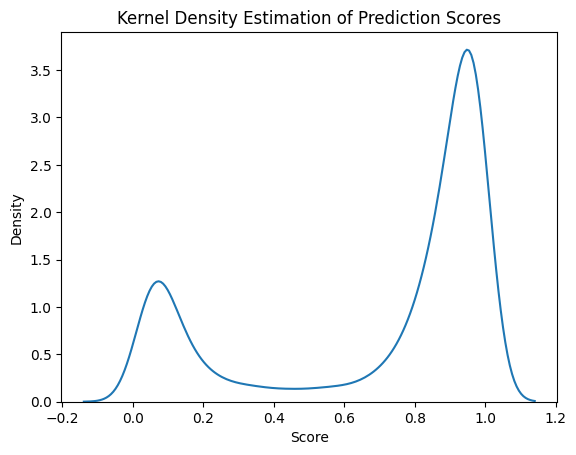

------------------------------------
Best threshold:  0.41847903
Best F1 score:  0.9643668574386702
####################################
XGB model evaluation for question 2
####################################
Training Accuracy: 1.0
Validation Accuracy: 0.9734776151071505
Training Precision: 1.0
Validation Precision: 0.9767640162012364
Training Recall: 1.0
Validation Recall: 0.996520226185298
Training F1 Score: 1.0
Validation F1 Score: 0.986543223167187
Training AUC Score: 1.0
Validation AUC Score: 0.5243470696143882


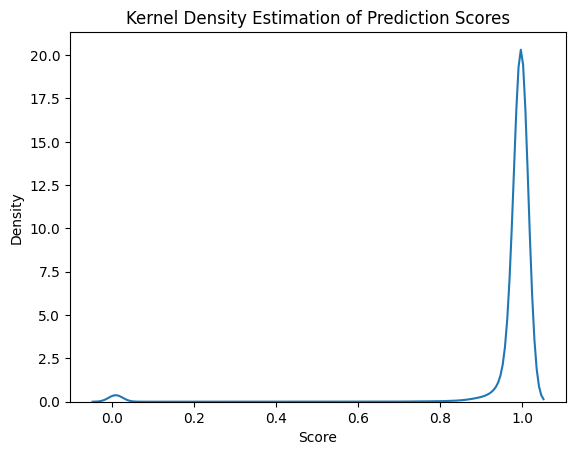

------------------------------------
Best threshold:  0.07996554
Best F1 score:  0.9975130295625094
####################################
XGB model evaluation for question 3
####################################
Training Accuracy: 1.0
Validation Accuracy: 0.9295565457245916
Training Precision: 1.0
Validation Precision: 0.936202098051809
Training Recall: 1.0
Validation Recall: 0.9922850011345586
Training F1 Score: 1.0
Validation F1 Score: 0.963428067856356
Training AUC Score: 1.0
Validation AUC Score: 0.5092143959921159


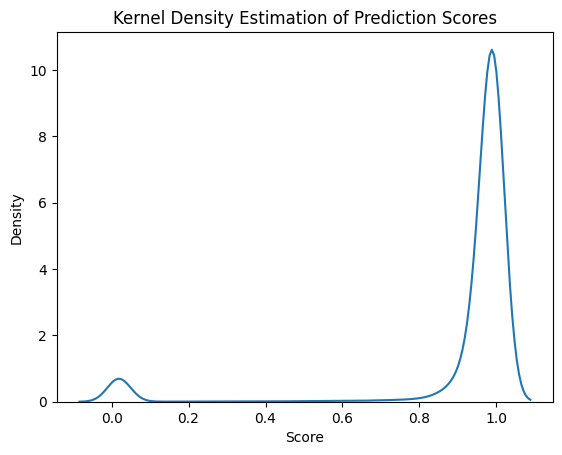

------------------------------------
Best threshold:  0.11393144
Best F1 score:  0.9931180757688577
####################################
XGB model evaluation for question 4
####################################
Training Accuracy: 0.9999668347041656
Validation Accuracy: 0.7958837258646297
Training Precision: 1.0
Validation Precision: 0.8438430983118173
Training Recall: 0.9999336694083312
Validation Recall: 0.9107717041800643
Training F1 Score: 0.9999668336041923
Validation F1 Score: 0.8760309278350514
Training AUC Score: 0.9999668347041656
Validation AUC Score: 0.6347946186547619


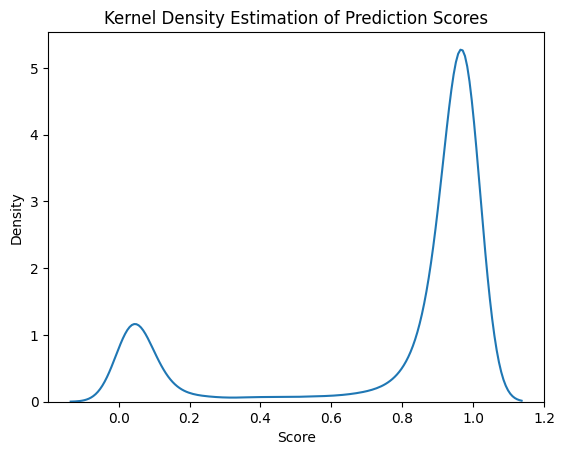

------------------------------------
Best threshold:  0.41529214
Best F1 score:  0.976332448974231
####################################
XGB model evaluation for question 5
####################################
Training Accuracy: 0.9998543547917274
Validation Accuracy: 0.6439635051983874
Training Precision: 0.9998058252427184
Validation Precision: 0.6690621631333094
Training Recall: 0.9999029031944849
Validation Recall: 0.7109583810614738
Training F1 Score: 0.9998543618622263
Validation F1 Score: 0.689374305812662
Training AUC Score: 0.9998543547917274
Validation AUC Score: 0.6355651504161237


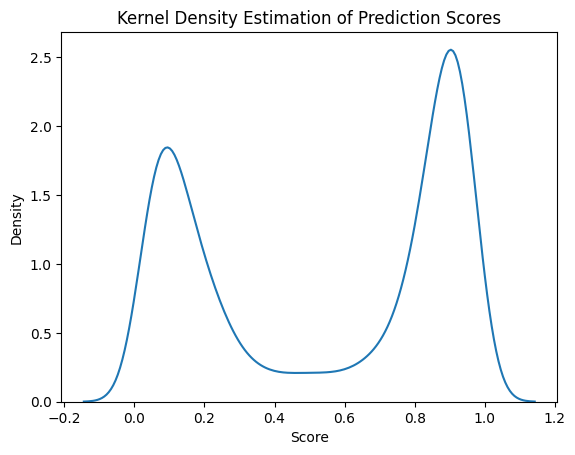

------------------------------------
Best threshold:  0.41160917
Best F1 score:  0.9377222852818766
####################################
XGB model evaluation for question 6
####################################
Training Accuracy: 0.9998970699238318
Validation Accuracy: 0.7774241459792065
Training Precision: 0.9997941822173436
Validation Precision: 0.8340446899322119
Training Recall: 1.0
Validation Recall: 0.8954177897574124
Training F1 Score: 0.999897080517342
Validation F1 Score: 0.8636422721955024
Training AUC Score: 0.9998970699238318
Validation AUC Score: 0.6181974292755157


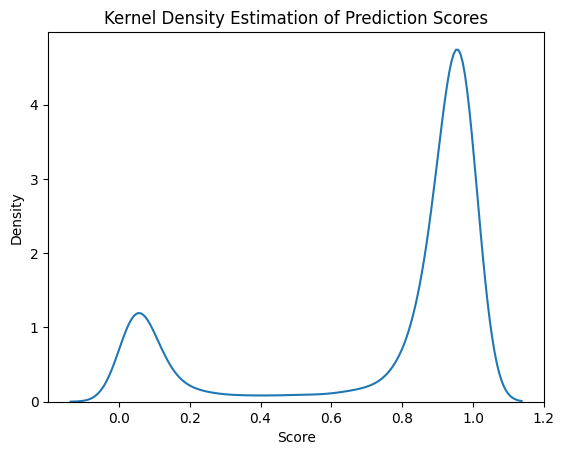

------------------------------------
Best threshold:  0.3852203
Best F1 score:  0.9733907891193105
####################################
XGB model evaluation for question 7
####################################
Training Accuracy: 0.9995299052578289
Validation Accuracy: 0.720560152768937
Training Precision: 0.9990606936416185
Validation Precision: 0.7809864554050601
Training Recall: 1.0
Validation Recall: 0.8691695108077361
Training F1 Score: 0.9995301261430586
Validation F1 Score: 0.8227217660519586
Training AUC Score: 0.9995299052578288
Validation AUC Score: 0.5766064763729574


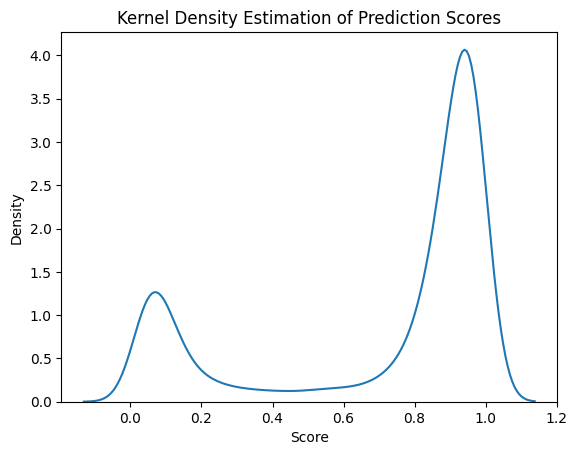

------------------------------------
Best threshold:  0.40809792
Best F1 score:  0.9647911241933657
####################################
XGB model evaluation for question 8
####################################
Training Accuracy: 0.9999567436629466
Validation Accuracy: 0.6102270316146828
Training Precision: 0.9999134948096886
Validation Precision: 0.6638103399028848
Training Recall: 1.0
Validation Recall: 0.7788203753351206
Training F1 Score: 0.9999567455339764
Validation F1 Score: 0.7167309175019275
Training AUC Score: 0.9999567436629466
Validation AUC Score: 0.5490400315079305


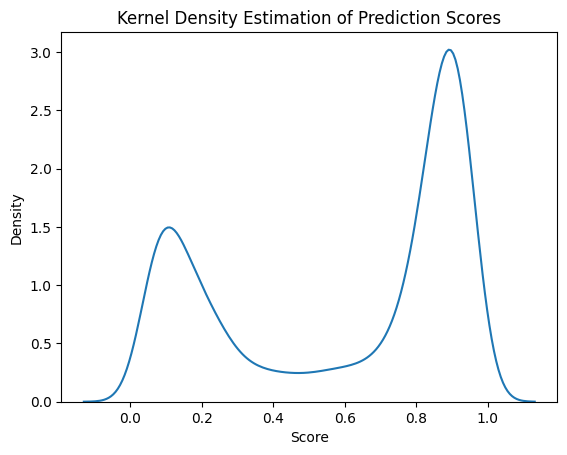

------------------------------------
Best threshold:  0.40040305
Best F1 score:  0.9394779935166929
####################################
XGB model evaluation for question 9
####################################
Training Accuracy: 0.9997458980688253
Validation Accuracy: 0.7175896456609379
Training Precision: 0.9994920542776287
Validation Precision: 0.8081890629293762
Training Recall: 1.0
Validation Recall: 0.8228875209848909
Training F1 Score: 0.9997459626202141
Validation F1 Score: 0.8154720643282962
Training AUC Score: 0.9997458980688253
Validation AUC Score: 0.6050346296759397


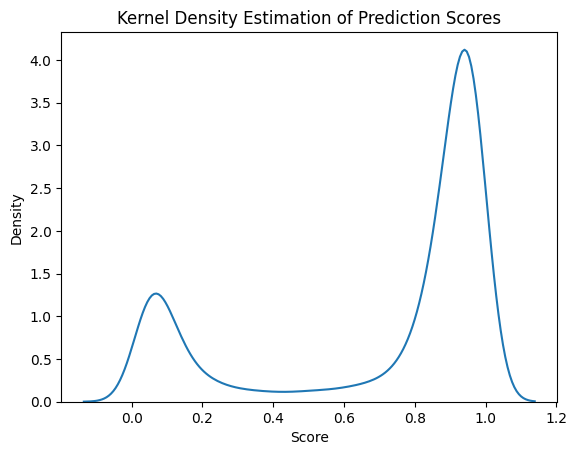

------------------------------------
Best threshold:  0.38134584
Best F1 score:  0.9678532047838502
####################################
XGB model evaluation for question 10
####################################
Training Accuracy: 1.0
Validation Accuracy: 0.5582431572246976
Training Precision: 1.0
Validation Precision: 0.6316614420062696
Training Recall: 1.0
Validation Recall: 0.3333333333333333
Training F1 Score: 1.0
Validation F1 Score: 0.4363833243096914
Training AUC Score: 1.0
Validation AUC Score: 0.5642701525054467


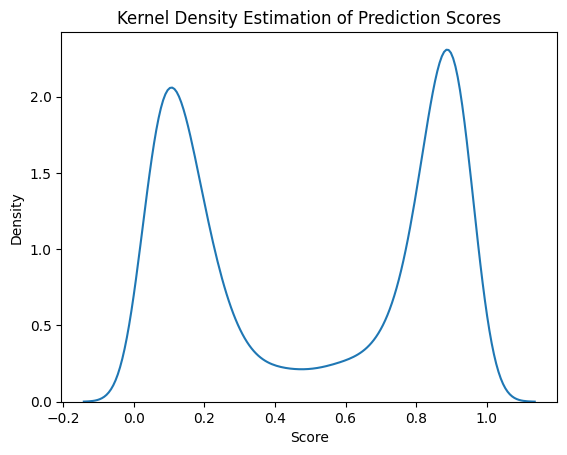

------------------------------------
Best threshold:  0.39773804
Best F1 score:  0.9246510866451111
####################################
XGB model evaluation for question 11
####################################
Training Accuracy: 0.9997933713530044
Validation Accuracy: 0.6257161043921069
Training Precision: 0.9995869134170522
Validation Precision: 0.6958483754512635
Training Recall: 1.0
Validation Recall: 0.7544031311154599
Training F1 Score: 0.9997934140395819
Validation F1 Score: 0.7239436619718309
Training AUC Score: 0.9997933713530044
Validation AUC Score: 0.5702798897835951


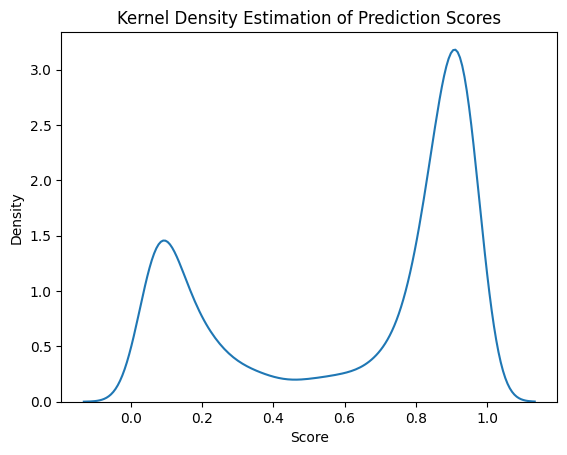

------------------------------------
Best threshold:  0.39360994
Best F1 score:  0.9468013468013468
####################################
XGB model evaluation for question 12
####################################
Training Accuracy: 1.0
Validation Accuracy: 0.8569913006577552
Training Precision: 1.0
Validation Precision: 0.875355969331873
Training Recall: 1.0
Validation Recall: 0.9743964886613021
Training F1 Score: 1.0
Validation F1 Score: 0.9222247865220402
Training AUC Score: 1.0
Validation AUC Score: 0.5223289632848994


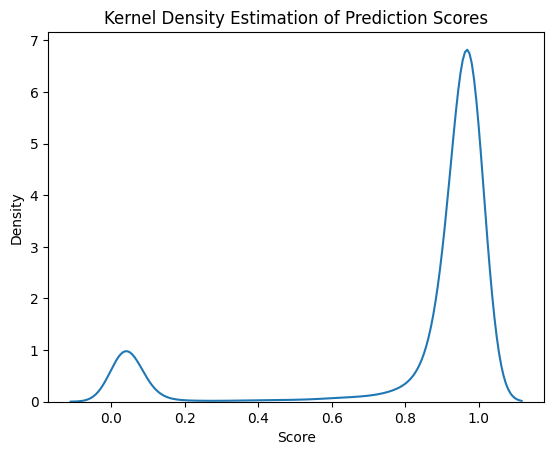

------------------------------------
Best threshold:  0.30127898
Best F1 score:  0.9849370558129382
####################################
XGB model evaluation for question 13
####################################
Training Accuracy: 0.9998905508938344
Validation Accuracy: 0.7161043921069382
Training Precision: 0.9999270286047869
Validation Precision: 0.5
Training Recall: 0.9998540678584458
Validation Recall: 0.2055306427503737
Training F1 Score: 0.9998905469006532
Validation F1 Score: 0.2913135593220339
Training AUC Score: 0.9998905508938344
Validation AUC Score: 0.5620245806344462


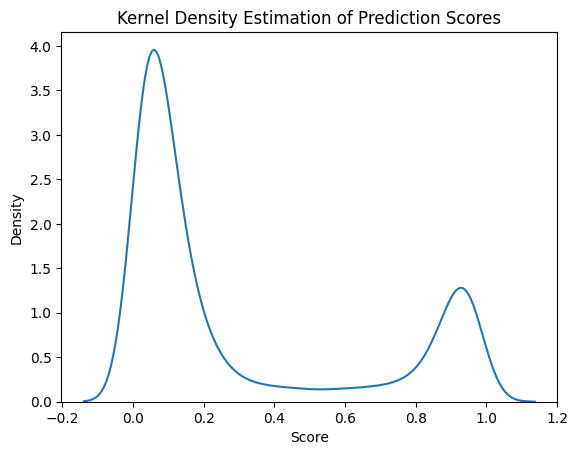

------------------------------------
Best threshold:  0.52660257
Best F1 score:  0.8935419173686322
####################################
XGB model evaluation for question 14
####################################
Training Accuracy: 0.9999622213826974
Validation Accuracy: 0.6770634415446637
Training Precision: 0.9999244484738592
Validation Precision: 0.7723785166240409
Training Recall: 1.0
Validation Recall: 0.7903460308229137
Training F1 Score: 0.9999622228098675
Validation F1 Score: 0.7812589824662258
Training AUC Score: 0.9999622213826974
Validation AUC Score: 0.5808088081901067


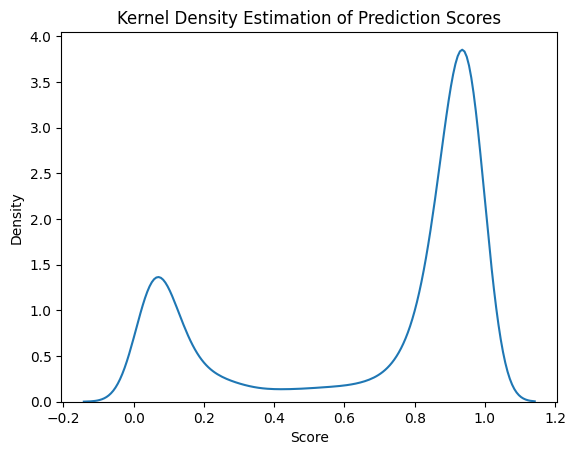

------------------------------------
Best threshold:  0.40672883
Best F1 score:  0.9624786475820227
####################################
XGB model evaluation for question 15
####################################
Training Accuracy: 0.9999490990532424
Validation Accuracy: 0.5830681094844048
Training Precision: 0.9998982084690554
Validation Precision: 0.654643823264202
Training Recall: 1.0
Validation Recall: 0.3145580589254766
Training F1 Score: 0.999949101644017
Validation F1 Score: 0.4249341527655839
Training AUC Score: 0.9999490990532424
Validation AUC Score: 0.5776532498369586


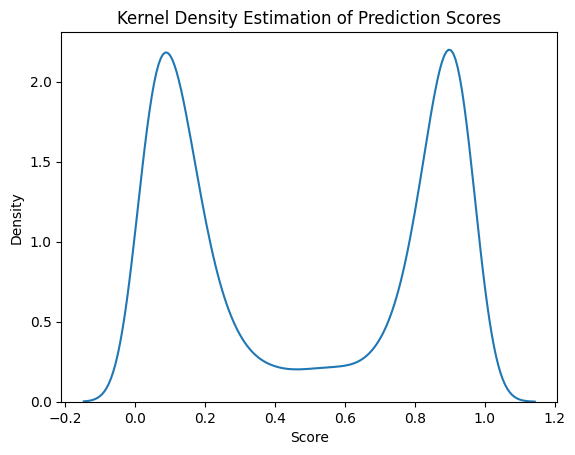

------------------------------------
Best threshold:  0.43057364
Best F1 score:  0.9282122420669325
####################################
XGB model evaluation for question 16
####################################
Training Accuracy: 1.0
Validation Accuracy: 0.7099511988117971
Training Precision: 1.0
Validation Precision: 0.7579223254705743
Training Recall: 1.0
Validation Recall: 0.9006228765571914
Training F1 Score: 1.0
Validation F1 Score: 0.8231336524776814
Training AUC Score: 1.0
Validation AUC Score: 0.520167492469959


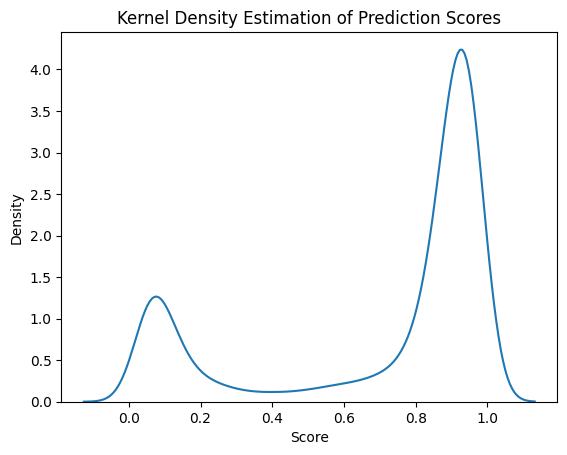

------------------------------------
Best threshold:  0.35850516
Best F1 score:  0.9644701392007184
####################################
XGB model evaluation for question 17
####################################
Training Accuracy: 0.999922420480993
Validation Accuracy: 0.6344154466369616
Training Precision: 0.9998448650325783
Validation Precision: 0.729076790336497
Training Recall: 1.0
Validation Recall: 0.764475271411339
Training F1 Score: 0.9999224264991078
Validation F1 Score: 0.7463565435006624
Training AUC Score: 0.999922420480993
Validation AUC Score: 0.5450865977672299


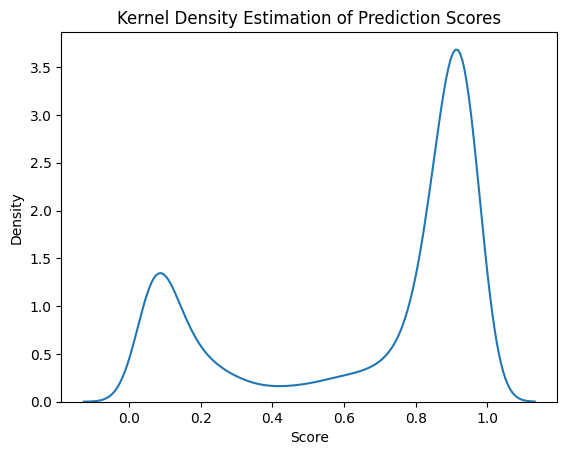

------------------------------------
Best threshold:  0.3808662
Best F1 score:  0.9549668082052509
####################################
XGB model evaluation for question 18
####################################
Training Accuracy: 1.0
Validation Accuracy: 0.9505622745597284
Training Precision: 1.0
Validation Precision: 0.9525329927628778
Training Recall: 1.0
Validation Recall: 0.9977703455964325
Training F1 Score: 1.0
Validation F1 Score: 0.9746270282042906
Training AUC Score: 1.0
Validation AUC Score: 0.5098500850789179


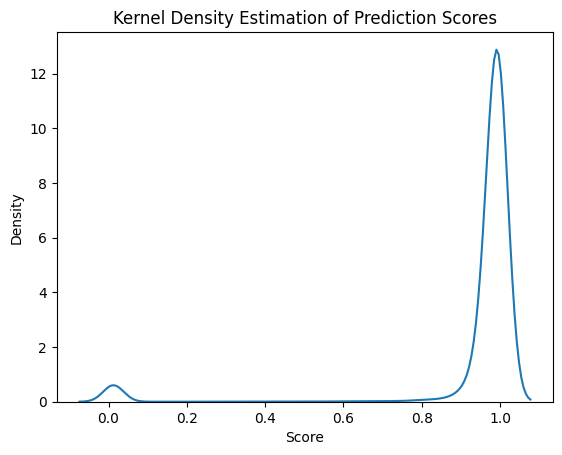

------------------------------------
Best threshold:  0.065773934
Best F1 score:  0.9949362590503265
####################################


In [22]:
warnings.filterwarnings("ignore")
targets = pd.read_csv('data/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))
pred_xgb = np.zeros((df1_features.shape[0],18))     
best_threshold_dict = {}

for t in range(1,19):
    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1_features
        df_train = df1_train
        df_valid = df1_valid
        FEATURES = FEATURES1

    elif t<=13: 
        grp = '5-12'
        df = df2_features
        df_train = df2_train
        df_valid = df2_valid
        FEATURES = FEATURES2

    elif t<=22: 
        grp = '13-22'
        df = df3_features
        df_train = df3_train
        df_valid = df3_valid
        FEATURES = FEATURES3
        
    xgb_params['n_estimators'] =300 #estimators_xgb[t-1]
    #xgb_params = best_params_dict[t]
     
    # TRAIN DATA
    train_users = df_train.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

    # Validation DATA
    valid_users = df_valid.index.values.astype('int')
    valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]

    
    X_train = df_train[FEATURES].astype('float32').fillna(-1)
    y_train = train_y['correct']

    # Use RandomOverSampler instead of SMOTE
    oversampler = RandomOverSampler(random_state=42)
    X_train, y_train = oversampler.fit_resample(X_train, y_train)


    # smote = SMOTE(random_state=42)
    # X_train, y_train = smote.fit_resample(X_train, train_y['correct'])

    clf =  XGBClassifier(**xgb_params)
    clf.fit(X_train, y_train, verbose = 0)
    # clf.save_model(f'XG_boost_models/230607/XGB_question{t}.xgb')
    # print(f'model XGB saved for question {t} with iterations = {estimators_xgb[t-1]}')


    

    #Evaluating the model
    print(f'XGB model evaluation for question {t}')
    

    print(f'####################################')

    # Variables
    #X_train = df_train[FEATURES].astype('float32')
    X_val = df_valid[FEATURES].astype('float32')
    #y_train = train_y['correct']
    y_val = valid_y['correct']

    X = df[FEATURES].astype('float32').fillna(-1)
    train_users = df.index.values
    y = targets.loc[targets.q==t].set_index('session').loc[train_users]['correct']

    # Make predictions
    y_train_preds = clf.predict(X_train)
    y_val_preds = clf.predict(X_val)

    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_preds)
    val_accuracy = accuracy_score(y_val, y_val_preds)

    train_precision = precision_score(y_train, y_train_preds)
    val_precision = precision_score(y_val, y_val_preds)

    train_recall = recall_score(y_train, y_train_preds)
    val_recall = recall_score(y_val, y_val_preds)

    train_f1 = f1_score(y_train, y_train_preds)
    val_f1 = f1_score(y_val, y_val_preds)

    train_auc = roc_auc_score(y_train, y_train_preds)
    val_auc = roc_auc_score(y_val, y_val_preds)

    # Print metrics
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Validation Accuracy: {val_accuracy}")
    print(f"Training Precision: {train_precision}")
    print(f"Validation Precision: {val_precision}")
    print(f"Training Recall: {train_recall}")
    print(f"Validation Recall: {val_recall}")
    print(f"Training F1 Score: {train_f1}")
    print(f"Validation F1 Score: {val_f1}")
    print(f"Training AUC Score: {train_auc}")
    print(f"Validation AUC Score: {val_auc}")

    # Predict probabilities
    y_scores = clf.predict_proba(X)[:, 1]

    sns.kdeplot(y_scores)
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.title('Kernel Density Estimation of Prediction Scores')
    plt.show()

    # Calculate precision-recall values for different thresholds
    precisions, recalls, thresholds = precision_recall_curve(y, y_scores)

    # Calculate F1 score for each threshold
    f1_scores = 2*recalls*precisions / (recalls+precisions)

    # Locate the index of the largest F1 score
    best_index = np.argmax(f1_scores)

    # Find the best threshold and corresponding F1 score
    best_threshold = thresholds[best_index]
    best_f1 = f1_scores[best_index]

    best_threshold_dict[t] = best_threshold
    
    print(f'------------------------------------')
    print('Best threshold: ', best_threshold)
    print('Best F1 score: ', best_f1)

    print(f'####################################')

In [107]:
with open('best_threshold.pkl', 'wb') as f:
    pickle.dump(best_threshold_dict, f)

print('Best threshold saved to best_threshold.pkl')

Best threshold saved to best_threshold.pkl


XGB model evaluation for question 1
####################################
Training Accuracy: 0.7818451907262984
Validation Accuracy: 0.7224697644812221
Training Precision: 0.9192051820728291
Validation Precision: 0.8596844578717691
Training Recall: 0.7670562454346238
Validation Recall: 0.742103738046943
Training F1 Score: 0.8362666241936768
Validation F1 Score: 0.796578538102644
Training AUC Score: 0.7940728019187074
Validation AUC Score: 0.7054417263927266


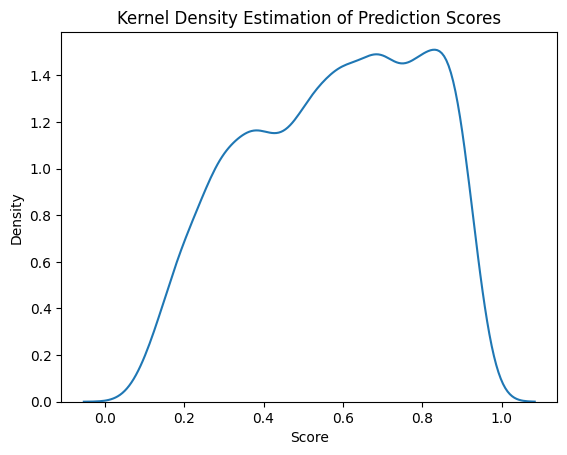

------------------------------------
Best threshold:  0.27089304
Best F1 score:  0.8531559728742827
####################################
XGB model evaluation for question 2
####################################
Training Accuracy: 0.848639185102658
Validation Accuracy: 0.8364099299809039
Training Precision: 0.9982765224052087
Validation Precision: 0.9872676343264578
Training Recall: 0.8469536961819659
Validation Recall: 0.8431926924749892
Training F1 Score: 0.9164103014854532
Validation F1 Score: 0.9095601173020529
Training AUC Score: 0.888320598090983
Validation AUC Score: 0.7042050418896686


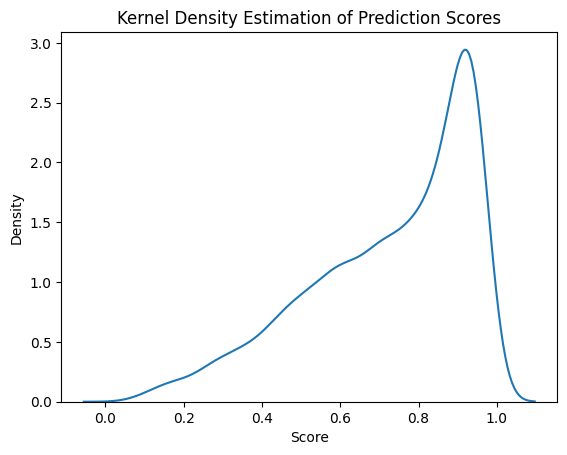

------------------------------------
Best threshold:  0.059915014
Best F1 score:  0.9876490172913758
####################################
XGB model evaluation for question 3
####################################
Training Accuracy: 0.9408987214175818
Validation Accuracy: 0.9132187566305963
Training Precision: 0.9646561443066516
Validation Precision: 0.945013357079252
Training Recall: 0.9723295454545454
Validation Recall: 0.9632402995234853
Training F1 Score: 0.9684776457272213
Validation F1 Score: 0.9540397797505338
Training AUC Score: 0.7351639720867602
Validation AUC Score: 0.5780253785199126


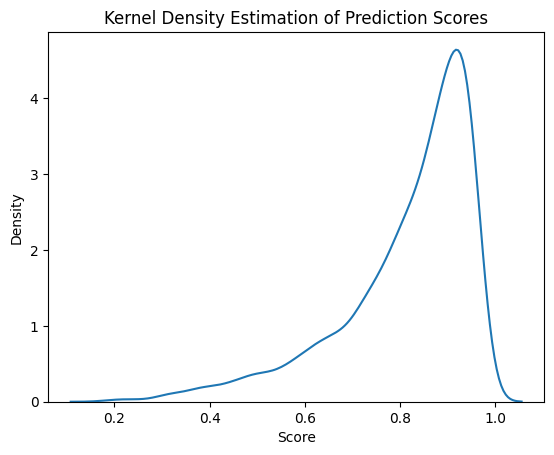

------------------------------------
Best threshold:  0.21779016
Best F1 score:  0.966864165020847
####################################
XGB model evaluation for question 4
####################################
Training Accuracy: 0.8465701098201496
Validation Accuracy: 0.8139189475917674
Training Precision: 0.8516508889401986
Validation Precision: 0.8286898457287589
Training Recall: 0.9786415494826214
Validation Recall: 0.9643622722400857
Training F1 Score: 0.9107407407407409
Validation F1 Score: 0.891393188854489
Training AUC Score: 0.6487429851839293
Validation AUC Score: 0.602976243153682


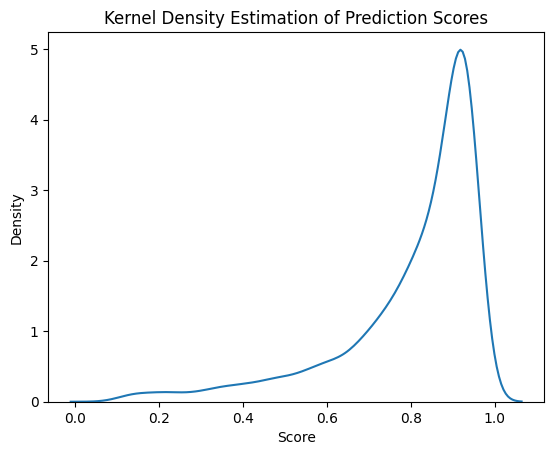

------------------------------------
Best threshold:  0.4168032
Best F1 score:  0.8943069608679752
####################################
XGB model evaluation for question 5
####################################
Training Accuracy: 0.785187543105735
Validation Accuracy: 0.6721833227243794
Training Precision: 0.7670940170940171
Validation Precision: 0.6767610269914417
Training Recall: 0.8714438294980095
Validation Recall: 0.7850324551355479
Training F1 Score: 0.8159461793717896
Validation F1 Score: 0.7268870426020858
Training AUC Score: 0.776365189602806
Validation AUC Score: 0.658036762429283


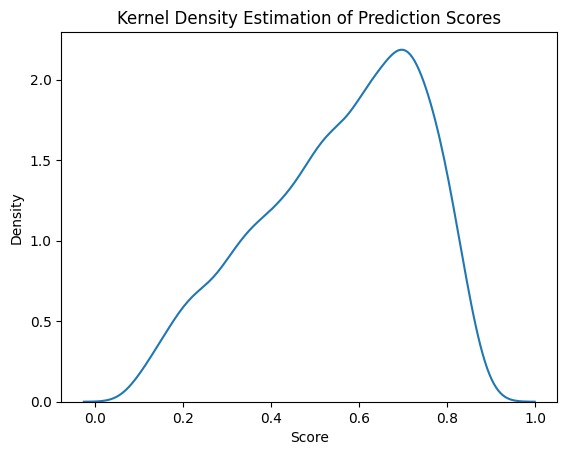

------------------------------------
Best threshold:  0.34624377
Best F1 score:  0.7467354995444884
####################################
XGB model evaluation for question 6
####################################
Training Accuracy: 0.8445010345376412
Validation Accuracy: 0.7984298748143434
Training Precision: 0.8390610438024231
Validation Precision: 0.8132092600998638
Training Recall: 0.9884718314691553
Validation Recall: 0.9657681940700809
Training F1 Score: 0.9076588639299328
Validation F1 Score: 0.8829472646623954
Training AUC Score: 0.6711535958094139
Validation AUC Score: 0.5726149046123087


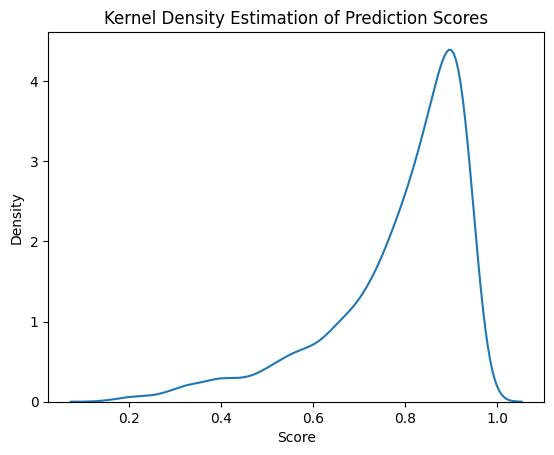

------------------------------------
Best threshold:  0.39842367
Best F1 score:  0.88719438392641
####################################
XGB model evaluation for question 7
####################################
Training Accuracy: 0.819831290784657
Validation Accuracy: 0.7545088054317844
Training Precision: 0.8097274184927846
Validation Precision: 0.7697233020809513
Training Recall: 0.9861141245389455
Validation Recall: 0.9573378839590444
Training F1 Score: 0.8892584621404813
Validation F1 Score: 0.8533400938014957
Training AUC Score: 0.6740606464988634
Validation AUC Score: 0.5580340213446016


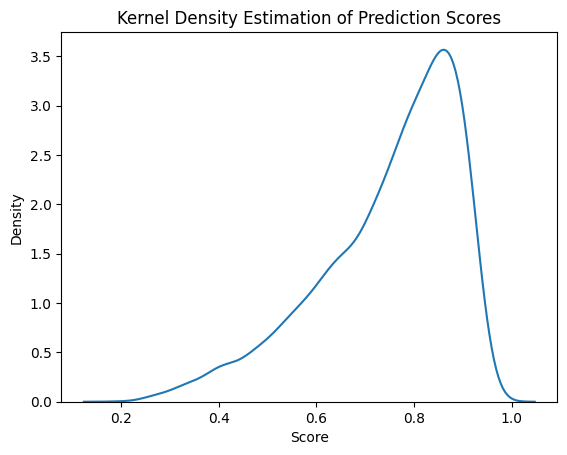

------------------------------------
Best threshold:  0.40568084
Best F1 score:  0.8553785352599728
####################################
XGB model evaluation for question 8
####################################
Training Accuracy: 0.6903283993845828
Validation Accuracy: 0.5885847655421176
Training Precision: 0.7862717630578347
Validation Precision: 0.7046611829220525
Training Recall: 0.6798165931308937
Validation Recall: 0.6028820375335121
Training F1 Score: 0.7291792325894307
Validation F1 Score: 0.649810366624526
Training AUC Score: 0.6934062389522782
Validation AUC Score: 0.5833959059848012


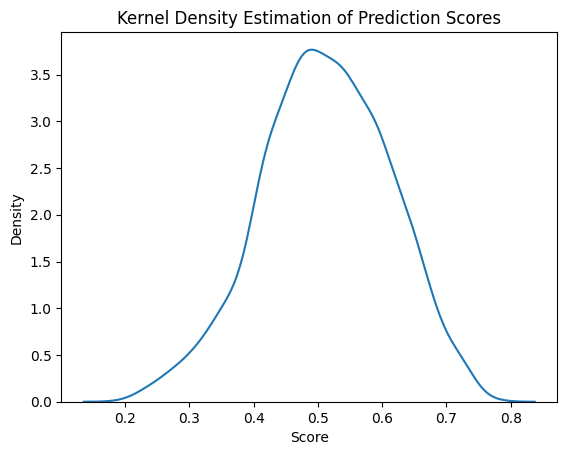

------------------------------------
Best threshold:  0.7816772
Best F1 score:  nan
####################################
XGB model evaluation for question 9
####################################
Training Accuracy: 0.8022176242771499
Validation Accuracy: 0.7750901761086357
Training Precision: 0.7937083382060578
Validation Precision: 0.7864630811303556
Training Recall: 0.9854798896471613
Validation Recall: 0.9655847789591494
Training F1 Score: 0.8792589713693484
Validation F1 Score: 0.8668676212007034
Training AUC Score: 0.6451537379270289
Validation AUC Score: 0.5714666651599961


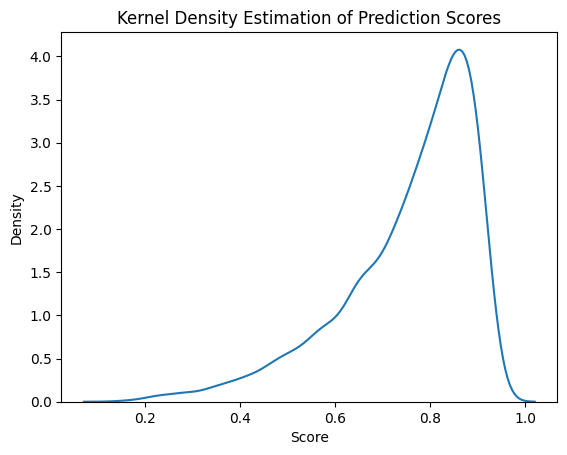

------------------------------------
Best threshold:  0.45127857
Best F1 score:  0.8691993565152827
####################################
XGB model evaluation for question 10
####################################
Training Accuracy: 0.7518170725237413
Validation Accuracy: 0.6456609378315298
Training Precision: 0.7379139891250618
Validation Precision: 0.6444015444015444
Training Recall: 0.7864292487619851
Validation Recall: 0.6902398676592225
Training F1 Score: 0.7613995715597265
Validation F1 Score: 0.6665335463258787
Training AUC Score: 0.7515711108097166
Validation AUC Score: 0.6444663390583694


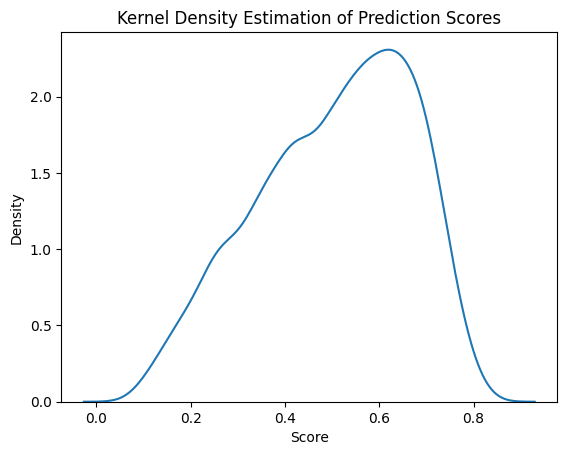

------------------------------------
Best threshold:  0.32995674
Best F1 score:  0.7055292259083727
####################################
XGB model evaluation for question 11
####################################
Training Accuracy: 0.720568730436628
Validation Accuracy: 0.6390833863781031
Training Precision: 0.8125343092406221
Validation Precision: 0.7395577395577395
Training Recall: 0.7340276055872386
Validation Recall: 0.6872146118721462
Training F1 Score: 0.77128837552651
Validation F1 Score: 0.7124260355029585
Training AUC Score: 0.7152360250158415
Validation AUC Score: 0.618349261005897


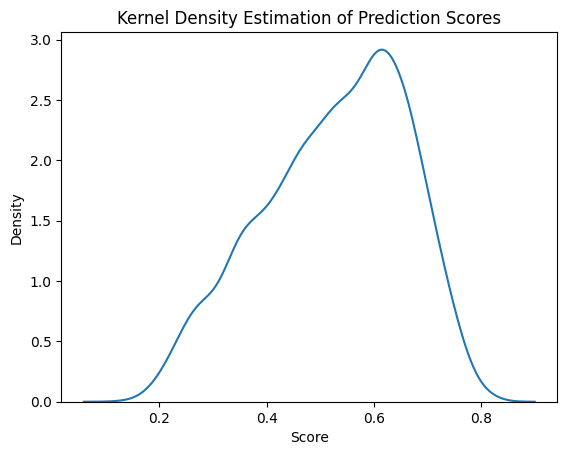

------------------------------------
Best threshold:  0.32468238
Best F1 score:  0.7938060309698453
####################################
XGB model evaluation for question 12
####################################
Training Accuracy: 0.8738925141917343
Validation Accuracy: 0.8699342244854658
Training Precision: 0.8723461435098092
Validation Precision: 0.8710638297872341
Training Recall: 0.9998767865943815
Validation Recall: 0.9982930992440868
Training F1 Score: 0.931767947871516
Validation F1 Score: 0.930348823997273
Training AUC Score: 0.5461745415585587
Validation AUC Score: 0.5040485104063571


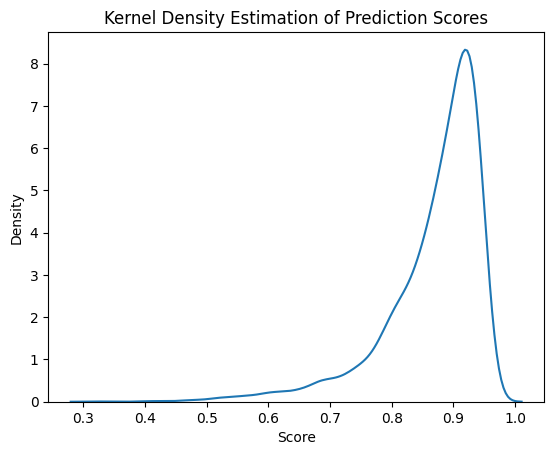

------------------------------------
Best threshold:  0.5562371
Best F1 score:  0.9308104411261826
####################################
XGB model evaluation for question 13
####################################
Training Accuracy: 0.8113958300175076
Validation Accuracy: 0.7371101209420751
Training Precision: 0.8958644743398106
Validation Precision: 0.6246851385390428
Training Recall: 0.3495334370139969
Validation Recall: 0.18535127055306427
Training F1 Score: 0.5028667319256048
Validation F1 Score: 0.2858789625360231
Training AUC Score: 0.6671417641107927
Validation AUC Score: 0.5706015612024581


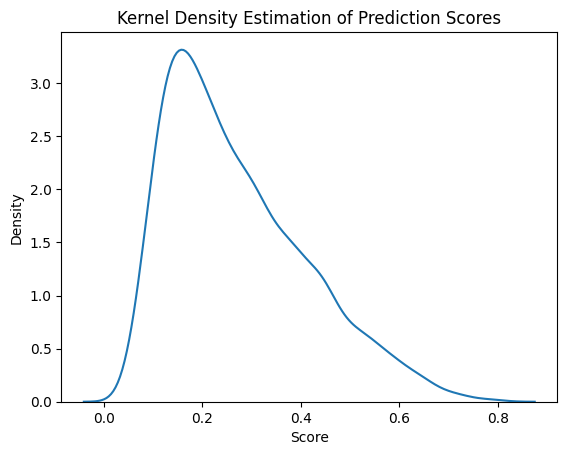

------------------------------------
Best threshold:  0.23171942
Best F1 score:  0.5036726128016789
####################################
XGB model evaluation for question 14
####################################
Training Accuracy: 0.7431693989071039
Validation Accuracy: 0.6863993210269468
Training Precision: 0.8634395566331833
Validation Precision: 0.8342993521991136
Training Recall: 0.7533811862485833
Validation Recall: 0.7115440535039256
Training F1 Score: 0.8046644877537023
Validation F1 Score: 0.7680477087256747
Training AUC Score: 0.7362381527965396
Validation AUC Score: 0.6650341931569864


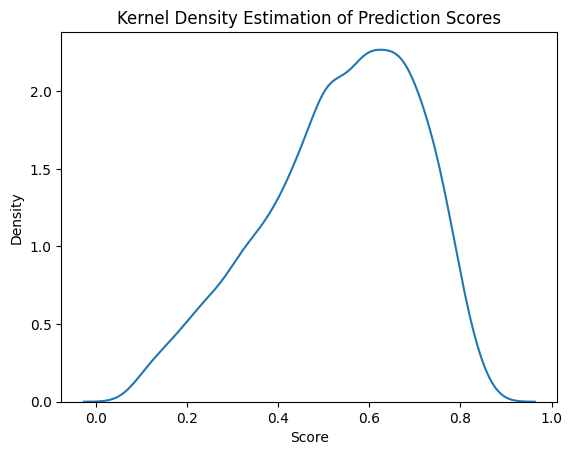

------------------------------------
Best threshold:  0.2109361
Best F1 score:  0.8516421291053229
####################################
XGB model evaluation for question 15
####################################
Training Accuracy: 0.732399596795586
Validation Accuracy: 0.6681519202206663
Training Precision: 0.7094466652640438
Validation Precision: 0.65
Training Recall: 0.7471748282738755
Validation Recall: 0.6984402079722704
Training F1 Score: 0.727822145478092
Validation F1 Score: 0.6733500417710944
Training AUC Score: 0.7329989991924198
Validation AUC Score: 0.6687627235287547


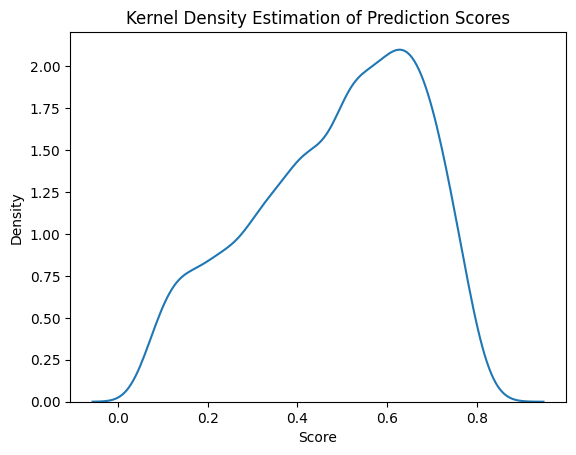

------------------------------------
Best threshold:  0.3571773
Best F1 score:  0.7069382119433896
####################################
XGB model evaluation for question 16
####################################
Training Accuracy: 0.7332484481935381
Validation Accuracy: 0.7504774029280713
Training Precision: 0.7327343293104365
Validation Precision: 0.7502124044180118
Training Recall: 0.9999274468548212
Validation Recall: 1.0
Training F1 Score: 0.8457290132547866
Validation F1 Score: 0.8572815533980582
Training AUC Score: 0.5038129141103952
Validation AUC Score: 0.502116850127011


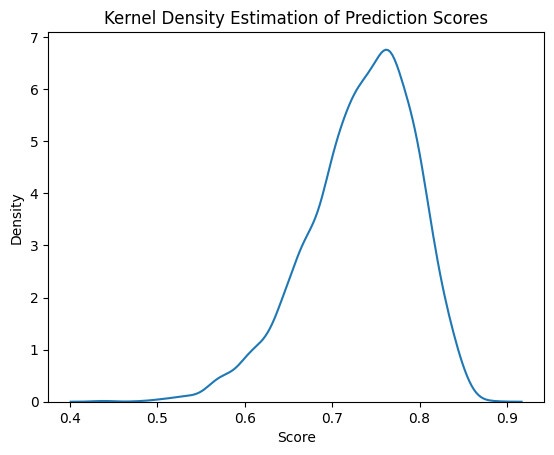

------------------------------------
Best threshold:  0.53520286
Best F1 score:  0.8580456976178902
####################################
XGB model evaluation for question 17
####################################
Training Accuracy: 0.7084195448034378
Validation Accuracy: 0.7027371101209421
Training Precision: 0.7016692123063496
Validation Precision: 0.7061356297093649
Training Recall: 0.9979053529868115
Validation Recall: 0.9891435464414958
Training F1 Score: 0.8239702773685222
Validation F1 Score: 0.8240170832809949
Training AUC Score: 0.5400669574130231
Validation AUC Score: 0.5060248870360664


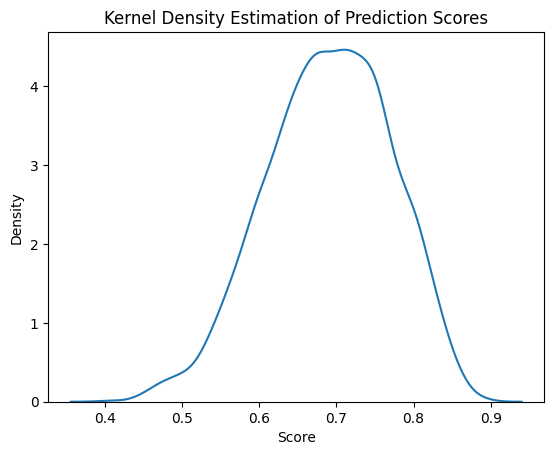

------------------------------------
Best threshold:  0.4371748
Best F1 score:  0.826211536065778
####################################
XGB model evaluation for question 18
####################################
Training Accuracy: 0.9430208499124622
Validation Accuracy: 0.9208572034797369
Training Precision: 0.9734592892487629
Validation Precision: 0.9601611459265891
Training Recall: 0.9663949983253322
Validation Recall: 0.9565217391304348
Training F1 Score: 0.9699142809120959
Validation F1 Score: 0.9583379872668379
Training AUC Score: 0.7307910820503667
Validation AUC Score: 0.587909992372235


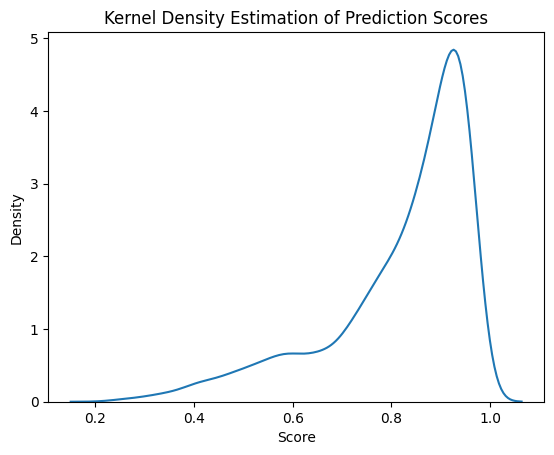

------------------------------------
Best threshold:  0.24218704
Best F1 score:  0.9753180384908123
####################################


In [29]:
warnings.filterwarnings("ignore")
targets = pd.read_csv('data/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))
pred_xgb = np.zeros((df1_features.shape[0],18))     
best_threshold_dict = {}

for t in range(1,19):
    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df_train = df1_train
        df_valid = df1_valid
        FEATURES = FEATURES1

    elif t<=13: 
        grp = '5-12'
        df_train = df2_train
        df_valid = df2_valid
        FEATURES = FEATURES2

    elif t<=22: 
        grp = '13-22'
        df_train = df3_train
        df_valid = df3_valid
        FEATURES = FEATURES3
        
    #xgb_params['n_estimators'] = estimators_xgb[t-1]
    xgb_params = best_params_dict[t]
     
    # TRAIN DATA
    train_users = df_train.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

    # Validation DATA
    valid_users = df_valid.index.values.astype('int')
    valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]



    clf =  XGBClassifier(**xgb_params)
    clf.fit(df_train[FEATURES].astype('float32'), train_y['correct'], verbose = 0)
    # clf.save_model(f'XG_boost_models/230607/XGB_question{t}.xgb')
    # print(f'model XGB saved for question {t} with iterations = {estimators_xgb[t-1]}')


    

    #Evaluating the model
    print(f'XGB model evaluation for question {t}')
    

    print(f'####################################')

    # Variables
    X_train = df_train[FEATURES].astype('float32')
    X_val = df_valid[FEATURES].astype('float32')
    y_train = train_y['correct']
    y_val = valid_y['correct']

    # Make predictions
    y_train_preds = clf.predict(X_train)
    y_val_preds = clf.predict(X_val)

    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_preds)
    val_accuracy = accuracy_score(y_val, y_val_preds)

    train_precision = precision_score(y_train, y_train_preds)
    val_precision = precision_score(y_val, y_val_preds)

    train_recall = recall_score(y_train, y_train_preds)
    val_recall = recall_score(y_val, y_val_preds)

    train_f1 = f1_score(y_train, y_train_preds)
    val_f1 = f1_score(y_val, y_val_preds)

    train_auc = roc_auc_score(y_train, y_train_preds)
    val_auc = roc_auc_score(y_val, y_val_preds)

    # Print metrics
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Validation Accuracy: {val_accuracy}")
    print(f"Training Precision: {train_precision}")
    print(f"Validation Precision: {val_precision}")
    print(f"Training Recall: {train_recall}")
    print(f"Validation Recall: {val_recall}")
    print(f"Training F1 Score: {train_f1}")
    print(f"Validation F1 Score: {val_f1}")
    print(f"Training AUC Score: {train_auc}")
    print(f"Validation AUC Score: {val_auc}")

    # Predict probabilities
    y_scores = clf.predict_proba(X_val)[:, 1]

    sns.kdeplot(y_scores)
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.title('Kernel Density Estimation of Prediction Scores')
    plt.show()

    # Calculate precision-recall values for different thresholds
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_scores)

    # Calculate F1 score for each threshold
    f1_scores = 2*recalls*precisions / (recalls+precisions)

    # Locate the index of the largest F1 score
    best_index = np.argmax(f1_scores)

    # Find the best threshold and corresponding F1 score
    best_threshold = thresholds[best_index]
    best_f1 = f1_scores[best_index]

    best_threshold_dict[t] = best_threshold
    
    print(f'------------------------------------')
    print('Best threshold: ', best_threshold)
    print('Best F1 score: ', best_f1)

    print(f'####################################')
    
    

### Defining threshold

In [19]:
best_threshold_dict

{1: 0.4396016,
 2: 0.3579287,
 3: 0.16466594,
 4: 0.33920395,
 5: 0.44691196,
 6: 0.43267626,
 7: 0.41654864,
 8: 0.40301898,
 9: 0.41965255,
 10: 0.42038122,
 11: 0.9927832,
 12: 0.22807506,
 13: 0.5398638,
 14: 0.4145013,
 15: 0.43154678,
 16: 0.3635212,
 17: 0.3921789,
 18: 0.119187}

# Exporting final models

In [19]:
warnings.filterwarnings("ignore")
targets = pd.read_csv('data/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))
pred_xgb = np.zeros((df1_features.shape[0],18))     

for t in range(1,19):
    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1_features
        FEATURES = FEATURES1

    elif t<=13: 
        grp = '5-12'
        df = df2_features
        FEATURES = FEATURES2

    elif t<=22: 
        grp = '13-22'
        df = df3_features
        FEATURES = FEATURES3
        
    #xgb_params['n_estimators'] =300 #estimators_xgb[t-1]
    #xgb_params = best_params_dict[t]
     
    # TRAIN DATA
    train_users = df.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

    
    X_train = df[FEATURES].astype('float32').fillna(-1)
    y_train = train_y['correct']

    # Use RandomOverSampler instead of SMOTE
    oversampler = RandomOverSampler(random_state=42)
    X_train, y_train = oversampler.fit_resample(X_train, y_train)

    # #SMOTE
    # smote = SMOTE(random_state=42)
    # X_train, y_train = smote.fit_resample(X_train, train_y['correct'])



    clf =  XGBClassifier(**xgb_params)
    clf.fit(X_train, y_train, verbose = 0)
    clf.save_model(f'XG_boost_models/230609/XGB_question{t}.xgb')
    print(f'model XGB saved for question {t}')

model XGB saved for question 1
model XGB saved for question 2
model XGB saved for question 3
model XGB saved for question 4
model XGB saved for question 5
model XGB saved for question 6
model XGB saved for question 7
model XGB saved for question 8
model XGB saved for question 9
model XGB saved for question 10
model XGB saved for question 11
model XGB saved for question 12
model XGB saved for question 13
model XGB saved for question 14
model XGB saved for question 15
model XGB saved for question 16
model XGB saved for question 17
model XGB saved for question 18


# Submission

In [ ]:
import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

In [ ]:
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

count = 0

for (sample_submission, test) in iter_test:
        
        session_id = test.session_id.values[0]
        grp = test.level_group.values[0]
        a,b = limits[grp]
  

        # ------------------- level 0-4 ---------------------------------
        if a == 1:
            FEATURES = FEATURES1
            test = (pl.from_pandas(test)
                  .drop(["fullscreen", "hq", "music"])
                  .with_columns(columns))
            test = feature_engineer_pl(test, grp, use_extra=True, feature_suffix='')
            test = test[FEATURES]
            

        # ------------------- level 5-12 ---------------------------------
        elif a == 4:
            FEATURES = FEATURES2
            test = (pl.from_pandas(test)
                  .drop(["fullscreen", "hq", "music"])
                  .with_columns(columns))
            test = feature_engineer_pl(test, grp, use_extra=True, feature_suffix='')
            test = test[FEATURES]

        # ------------------- level 13-22 ---------------------------------    
        elif a == 14:
            FEATURES = FEATURES3
            test = (pl.from_pandas(test)
                  .drop(["fullscreen", "hq", "music"])
                  .with_columns(columns))
            test = feature_engineer_pl(test, grp, use_extra=True, feature_suffix='')
            test = test[FEATURES]
    
        for t in range(a,b):

            clf = XGBClassifier()
            clf.load_model(f'/kaggle/working/XGB_question{t}.xgb')

            mask = sample_submission.session_id.str.contains(f'q{t}')
            p = clf.predict_proba(test.astype('float32'))[:,1]
            sample_submission.loc[mask,'correct'] = int((p.item())>0.625)  
                
        env.predict(sample_submission)

In [ ]:
pd.read_csv('submission.csv').head(10)

# DEBUG

### Usefull when you make updates

In [ ]:
"""
test = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/test.csv')
test = test.drop('session_level', axis=1)
test_level1 = test[test['level_group'] == '0-4']
test_level2 = test[test['level_group'] == '5-12']
test_level3 = test[test['level_group'] == '13-22']
sample_submission = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/sample_submission.csv')

limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}


for test_level in [test_level1,test_level2,test_level3]:
    l = np.unique(test_level['level_group']).tolist()
    print(f'\n***************** level = {l}*******************\n')
    for session_id in [20090109393214576,20090312143683264,20090312331414616]:
        print(f'--------- {session_id} ---------')
        
        test_level_session = test_level[test_level['session_id']==session_id]          
        #display(test_level_session.head(2))
        #------------------------------------
        #grp = test.level_group.values[0]
        grp = l[0] 
        a,b = limits[grp]
        #------------------------------------           
        columns = [

            pl.col("page").cast(pl.Float32),
            (
                (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1)) 
                 .fill_null(0)
                 .clip(0, 1e9)
                 .over(["session_id", "level_group"])
                 .alias("elapsed_time_diff")
            ),
            (
                (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1)) 
                 .abs()
                 .over(["session_id", "level_group"])
                .alias("location_x_diff") 
            ),
            (
                (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1)) 
                 .abs()
                 .over(["session_id", "level_group"])
                .alias("location_y_diff") 
            ),
            pl.col("fqid").fill_null("fqid_None"),
            pl.col("text_fqid").fill_null("text_fqid_None")
        ]

        # ------------------- level 0-4 ---------------------------------
        if a == 1:
            print('GRP =',grp)
            FEATURES = FEATURES1
            
            test = (pl.from_pandas(test_level.drop(["fullscreen", "hq", "music"],axis=1))
                  .with_columns(columns))
            test = feature_engineer_pl(test, grp, use_extra=True, feature_suffix='')
            test = test[FEATURES]
            test = test.fillna(-1)
            level = 3
            w = 0
            print('test shape',test_level.shape)
            print('level =',level)
          
            scaler = scaler_0

        # ------------------- level 5-12 ---------------------------------
        elif a == 4:
            print('GRP =',grp)
            FEATURES = FEATURES2
            test = (pl.from_pandas(test_level.drop(["fullscreen", "hq", "music"],axis=1))
                  .with_columns(columns))
            test = feature_engineer_pl(test, grp, use_extra=True, feature_suffix='')
            test = test[FEATURES]
            test = test.fillna(-1)
            print('test shape',test.shape) # **********************
            level = 10 
            print('level =',level)
            scaler = scaler_1

        # ------------------- level 13-22 ---------------------------------    
        elif a == 14:
            print('GRP =',grp)
            FEATURES = FEATURES3
            test = (pl.from_pandas(test_level.drop(["fullscreen", "hq", "music"],axis=1))
                  .with_columns(columns))
            test = feature_engineer_pl(test, grp, use_extra=True, feature_suffix='')
            test = test[FEATURES]
            test = test.fillna(-1)
            print('test shape',test.shape) # **********************
            
            level = 5
            print('level =',level)
            scaler = scaler_2
         

        # ---------- Predictions for the session_id and the level_group -------------    

        X_test = scaler.transform(test)
        #X_test = scaler.transform(test)
        
        X_test = torch.from_numpy(X_test.astype(np.float32))
        pred_test = np.zeros((X_test.shape[0],level))

        for i in range(N_SPLITS) :
            with torch.no_grad():
                model = dict_level[level][i]
                model.eval()
                pred = model(X_test.float())
                pred_test += pred.numpy()/N_SPLITS
               
      
        pred_test = pred_test.tolist()[0]
        print(pred_test)           
            
        for t in range(a,b):
            w = t-a
            print(f'---------- t = {t} ----  t-a = {w} -------------')
            mask = sample_submission.session_id.str.contains(f'q{t}')
            sample_submission.loc[mask,'correct'] = int(pred_test[w]>0.61) 
            print('prediction = ',int(pred_test[w]>0.61))                  
           
        #env.predict(sample_submission)
           
"""